# Import the packages

Before running your first cell, make sure GPU is enabled! Click the three dots in the upper right, go to 'Accelerator' and select 'GPU P100'

In [1]:
#%matplotlib ipympl

import time
import torch
import librosa
import numpy as np
import torch.nn as nn
import torch.nn.functional as F 
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from torch import nn
from torchmetrics import F1Score
from collections import OrderedDict
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from inception import Inception, InceptionBlock



# Load and preprocess the training data

In [2]:
# Loading the data files from Kaggle into this workspace
basal_train = np.load('basal_train.npy')
pre_seizure_train = np.load('pre_seizure_train.npy')

# Checking the dimensions of our data
print(basal_train.shape)
print(pre_seizure_train.shape)

# Original train data is 3x2x24000, 3 subjects, 2 electrodes and 240 seconds
# Below we will concatenate across subjects

# Reshape basal_train to a 2x72000 matrix (2 electrodes, 720 seconds of data)
basal_train_reshaped = basal_train.reshape((basal_train.shape[1], -1))
pre_seizure_train_reshaped = pre_seizure_train.reshape((pre_seizure_train.shape[1], -1))

# Check the dimensions of basal_train_reshaped
print(basal_train_reshaped.shape)
print(pre_seizure_train_reshaped.shape)

(3, 2, 240000)
(3, 2, 60000)
(2, 720000)
(2, 180000)


## Slice data into 2s segments

In [3]:
# Create a function to receive longer segments of data and divide it into smaller blocks

# The function receives the data variable, the size of the smaller blocks it will be divided into
# and the related training labels (which tell whether that block is pre-epileptic or not)
def create_windows_per_recording(data, window_size, label):
    # Initialize the variables
    windows = []
    labels = []
    
    # Compute the number of windows based on the length of the data and the size of the window
    num_windows = (data.shape[1] - window_size) // window_size + 1
    for i in range(num_windows):
        # Fill the windows with segments of the original data
        window = data[:, i * window_size : i * window_size + window_size]
        windows.append(window)
        labels.append(label)
        
    # Return the resulting smaller windows and its labels
    return np.array(windows), np.array(labels)

### Balance the labels 50/50

In [11]:
def balance_labels(X_train, X_val, y_train, y_val):
    # Calculate the number of pre-epileptic samples
    num_pre_epileptic_train = np.sum(y_train == 1)
    num_pre_epileptic_val = np.sum(y_val == 1)
    
    # Calculate the number of desired basal samples
    desired_num_basal_train = num_pre_epileptic_train
    desired_num_basal_val= num_pre_epileptic_val

    # Select the basal samples for the train set
    basal_train_indices = np.where(y_train == 0)[0]
    
    # Select the basal samples for the validation set
    basal_val_indices = np.where(y_val == 0)[0]

    selected_basal_train_indices = np.random.choice(basal_train_indices, size=desired_num_basal_train, replace=False)
    selected_basal_val_indices = np.random.choice(basal_val_indices, size=desired_num_basal_val, replace=False)

    selected_pre_epileptic_train_indices = np.where(y_train == 1)[0]
    selected_pre_epileptic_val_indices = np.where(y_val == 1)[0]

    # Combine the selected pre-epileptic and basal windows for the validation set
    selected_train_indices = np.concatenate([selected_pre_epileptic_train_indices, selected_basal_train_indices])
    
    # Combine the selected pre-epileptic and basal windows for the validation set
    selected_val_indices = np.concatenate([selected_pre_epileptic_val_indices, selected_basal_val_indices])

    # Update the training and validation sets
    X_val = X_val[selected_val_indices]
    y_val = y_val[selected_val_indices]

    # Update the training and validation sets
    X_train = X_train[selected_train_indices]
    y_train = y_train[selected_train_indices]

    return X_train, X_val, y_train, y_val


## Set parameters and split train-test data


In [12]:
# Parameters
window_size = 2000  # equivalent to two seconds of data, equal to the test samples

# Create windows
# Assign '0' to the basal (non pre-epileptic) data and '1' to pre-epileptic
basal_windows, basal_labels = create_windows_per_recording(basal_train_reshaped, window_size, 0) 
pre_seizure_windows, pre_seizure_labels = create_windows_per_recording(pre_seizure_train_reshaped, window_size, 1)

# Concatenate the training windows and their labels
X_train = np.concatenate([basal_windows, pre_seizure_windows])
y_train = np.concatenate([basal_labels, pre_seizure_labels])
# remove the singleton dimension
X_train = np.squeeze(X_train)
y_train = np.squeeze(y_train)


##### Data augmentations #####

# Noise
noise = np.random.normal(0, 0.05, X_train.shape)
aug_noise = X_train + noise

# Scaling
scaling_factor = np.random.uniform(0.5, 1.5)
aug_scale = X_train * scaling_factor

# Flipping
aug_flipped = X_train[:, ::-1]

###############################

# Append augmented data to original training dataset
X_train = np.concatenate([X_train, aug_noise, aug_scale, aug_flipped])
y_train = np.concatenate([y_train, y_train, y_train, y_train])

# Split data into training and validation sets 
# 'test_size' specifies % of data towards validation set, 0.2 = 20%
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Balance the training and validation set labels
X_train, X_val, y_train, y_val = balance_labels(X_train, X_val, y_train, y_val)


# Scaling the data 
""" scaler = RobustScaler()
X_train = X_train.reshape(-1, X_train.shape[-1])
X_train = scaler.fit_transform(X_train)
X_train = X_train.reshape(-1, 2, 2000)
X_val = X_val.reshape(-1, X_val.shape[-1])
X_val = scaler.transform(X_val)
X_val = X_val.reshape(-1, 2, 2000) """

' scaler = RobustScaler()\nX_train = X_train.reshape(-1, X_train.shape[-1])\nX_train = scaler.fit_transform(X_train)\nX_train = X_train.reshape(-1, 2, 2000)\nX_val = X_val.reshape(-1, X_val.shape[-1])\nX_val = scaler.transform(X_val)\nX_val = X_val.reshape(-1, 2, 2000) '

In [13]:
# print the shapes of the data
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_val shape: ", X_val.shape)
print("y_val shape: ", y_val.shape)

# Print the number of pre-epileptic and basal windows in the training and validation sets
print("Number of pre-epileptic windows in the training set: ", np.sum(y_train == 1))
print("Number of basal windows in the training set: ", np.sum(y_train == 0))

print("Number of pre-epileptic windows in the validation set: ", np.sum(y_val == 1))
print("Number of basal windows in the validation set: ", np.sum(y_val == 0))

# Print the proportions of pre-epileptic and basal windows in the training and validation sets
print("Proportion of pre-epileptic windows in the training set: ", np.sum(y_train == 1) / len(y_train))
print("Proportion of basal windows in the training set: ", np.sum(y_train == 0) / len(y_train))

print("Proportion of pre-epileptic windows in the validation set: ", np.sum(y_val == 1) / len(y_val))
print("Proportion of basal windows in the validation set: ", np.sum(y_val == 0) / len(y_val))

X_train shape:  (544, 2, 2000)
y_train shape:  (544,)
X_val shape:  (176, 2, 2000)
y_val shape:  (176,)
Number of pre-epileptic windows in the training set:  272
Number of basal windows in the training set:  272
Number of pre-epileptic windows in the validation set:  88
Number of basal windows in the validation set:  88
Proportion of pre-epileptic windows in the training set:  0.5
Proportion of basal windows in the training set:  0.5
Proportion of pre-epileptic windows in the validation set:  0.5
Proportion of basal windows in the validation set:  0.5


## Transform the data into Pytorch datasets and loaders

In [14]:
# Convert data to PyTorch tensors (a data structure)
tensor_x_train = torch.Tensor(X_train) 
tensor_x_val = torch.Tensor(X_val) 
tensor_y_train = torch.Tensor(y_train)
tensor_y_val = torch.Tensor(y_val)

# Create Tensor datasets
train_data = TensorDataset(tensor_x_train, tensor_y_train)
val_data = TensorDataset(tensor_x_val, tensor_y_val)

# Dataloaders (to feed the data into the model during training)
# 'batch_size' defines the chunk size of data to be fed in each training step
batch_size = 64
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
val_loader = DataLoader(val_data, shuffle=True, batch_size=batch_size, drop_last=True)


In [15]:
print(tensor_x_val.shape,tensor_y_val.shape)
print(tensor_x_train.shape,tensor_y_train.shape)

torch.Size([176, 2, 2000]) torch.Size([176])
torch.Size([544, 2, 2000]) torch.Size([544])


### Check if the dataloader is functioning properly

In [16]:
train_iter = iter(train_loader)
try:
    data, label = next(train_iter)
except StopIteration:
    print("The train_loader is empty.")
    
val_iter = iter(val_loader)
try:
    data, label = next(val_iter)
except StopIteration:
    print("The val_loader is empty.")

## Test spectrogram conversion

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

X_train_reshaped = X_train.transpose(0, 2, 1).reshape(-1, 2000)
X_val_reshaped = X_val.transpose(0, 2, 1).reshape(-1, 2000)
print(X_train_reshaped.shape)
print(X_val_reshaped.shape)

In [28]:
def data_to_spectrogram(data):
    # Initialize a list to store spectrograms
    spectrograms = []
    # Loop through each EEG sample and compute its STFT
    for sample in data:
        # Convert the data sample to a frequency domain representation using the STFT
        spectrogram = librosa.stft(data, n_fft=1024)
        # Normalize the spectrogram
        spectrogram = librosa.amplitude_to_db(spectrogram)
        spectrograms.append(spectrogram)
        
    return spectrograms


In [ ]:
# Convert the list of spectrograms to a numpy array
spectrograms_train = torch.tensor(np.array(data_to_spectrogram(X_train_reshaped)))
spectrograms_val = torch.tensor(np.array(data_to_spectrogram(X_val_reshaped)))

# Convert the spectrogram to a PyTorch tensor
#spectrogram = torch.tensor(spectrogram)

print(spectrograms_train.shape)
print(spectrograms_val.shape)

In [ ]:
from scipy.signal import spectrogram, welch

srate = 1000
window_length = 0.5*srate
overlap = 0.9*window_length
nfft = 2**13

# normalize this spectrogram in decibels
def normalize_spectrogram(Sxx):
    Sxx = 10*np.log10(Sxx)
    Sxx = Sxx - np.max(Sxx)
    return Sxx

F,T,Sxx = spectrogram(X_train_reshaped[0],srate,nperseg=int(window_length),noverlap=overlap,nfft=nfft)

normalized_Sxx = normalize_spectrogram(Sxx)

plt.figure(figsize=(12,6))
plt.pcolormesh(T,F,Sxx)
plt.ylim([0,25])
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.colorbar(label='Power');

# Build the model

## LSTM model

In [ ]:
# Current model is an LSTM (Long Short Term Memory) using PyTorch

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers):
        super(LSTM, self).__init__()

        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        # Define the LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True)

        # Define the output layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        batch_size = x.size(0)

        # Initialize hidden state
        h0 = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(x.device) 

        # Initialize cell state
        c0 = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(x.device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])

        return out

# Initialize model parameters
# 'input_dim' = number of nodes in the first layer of the model, has to be equal to training input data
# 'output_dim' = number of nodes in the last layer of the model, will output model prediction
# 'n_layers' = number of hidden layers, meaning layers between input and output 
# 'hidden_dim' = number of nodes in each hidden layer, 100 = layer can store 100 units of information at each time step


model = LSTM(input_dim=2000, hidden_dim=100, output_dim=1, n_layers=500)
print(model)

## InceptionTime model

In [17]:
class Flatten(nn.Module):
	def __init__(self, out_features):
		super(Flatten, self).__init__()
		self.output_dim = out_features

	def forward(self, x):
		return x.view(-1, self.output_dim)
    
class Reshape(nn.Module):
	def __init__(self, out_shape):
		super(Reshape, self).__init__()
		self.out_shape = out_shape

	def forward(self, x):
		return x.view(-1, *self.out_shape)

InceptionTime = nn.Sequential(
                    Reshape(out_shape=(2,2000)),
                    InceptionBlock(
                        in_channels=2, 
                        n_filters=32, 
                        kernel_sizes=[5, 11, 23],
                        bottleneck_channels=32,
                        use_residual=True,
                        activation=nn.ReLU()
                    ),
                    nn.Dropout(0.2),
                    InceptionBlock(
                        in_channels=32*4, 
                        n_filters=32, 
                        kernel_sizes=[5, 11, 23],
                        bottleneck_channels=32,
                        use_residual=True,
                        activation=nn.ReLU()
                    ),
                    nn.Dropout(0.2),
                    nn.AdaptiveAvgPool1d(output_size=1),
                    Flatten(out_features=32*4*1),
                    nn.Linear(in_features=4*32*1, out_features=1)
        )

## CNN model

## Train the model

In [ ]:
# LSTM model

# Loss and optimization
# 'device' sets which computing unit will be used, GPU(cuda) is preferred
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 'criterion' specifies the method to compute loss (an 'error' metric for model prediction)
# Here we use BCE (Binary Cross Entropy)
criterion = nn.BCEWithLogitsLoss().to(device)
# 'optimizer' sets the algorithm that is used to adjust the weights of the model
# Here we use ADAM, which is a fairly popular optimization algo
# 'lr' means Learning Rate, which modulates how fast the weights are adjusted
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# .to(device) simply means whe are directing this to the GPU or CPU (chosen above)
model = model.to(device)

# Initialize training losses, validation losses and F1 scores
train_losses = []
val_losses = []
val_f1_scores = []


####### Training loop #######

# 'F1Score' is the evaluation metric we use to assess model performance
# simple 'accuracy' is the most popular option, but has its tradeoffs
f1 = F1Score(task="binary").to(device)

# epoch is each training step
for epoch in range(100):
    # initialize single evaluation metrics (for this iteration)
    loss = None
    val_loss = None
    val_f1 = None
    
    # Train the model
    model.train()
    # receive inputs and labels from the training dataloader
    for inputs, labels in train_loader:
        # send inputs and labels to device
        inputs, labels = inputs.to(device), labels.to(device) 
        # clear out the gradients of all parameters that the optimizer is tracking
        optimizer.zero_grad()
        # make model predictions
        outputs = model(inputs)
        # compute training loss based on predicted values
        loss = criterion(outputs, labels)
        # perform back propagation
        loss.backward()
        # apply optimizer to adjust the weights
        optimizer.step()
    
    # compute model performance metrics
    model.eval()
    with torch.no_grad():
        # receive inputs and labels from the validation dataloader
        for inputs, labels in val_loader:
            # send inputs and labels to device
            inputs, labels = inputs.to(device), labels.to(device)
            # make model predictions
            outputs = model(inputs)
            # compute training loss and F1Score based on predicted values
            val_loss = criterion(outputs, labels)
            val_f1 = f1(torch.sigmoid(outputs).round(), labels)
            
    # add this iteration evaluation metrics to the grouping variables        
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())
    val_f1_scores.append(val_f1.item())
    
    # Print the loss and F1Score values across epochs
    if loss is not None and val_loss is not None and val_f1 is not None:
        print(f'Epoch {epoch+1}/{10}, Loss: {loss.item()}, Val Loss: {val_loss.item()}, Val F1 Score: {val_f1.item()}')
    else:
        print('No data in the DataLoader')


In [20]:
# InceptionTime model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.BCEWithLogitsLoss().to(device) #BCEWithLogitsLoss is the same as BCE, but with a sigmoid layer added before the BCE
optimizer = torch.optim.Adam(InceptionTime.parameters(), lr=0.001, weight_decay=0.01) #weight_decay is a regularization parameter
InceptionTime = InceptionTime.to(device)

""" # Load the model from a saved point if exists
try:
    InceptionTime.load_state_dict(torch.load('best_model.pth'))
    print("Model loaded successfully")
except FileNotFoundError:
    print("No saved model found, starting training from scratch")
 """
 
 
train_losses = []
val_losses = []

min_val_loss = np.inf
patience = 100
patience_counter = 0

# Training loop
for epoch in range(100):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        optimizer.zero_grad()
        outputs = InceptionTime(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Validation loss computation
    val_running_loss = 0.0
    for i, data in enumerate(val_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        outputs = InceptionTime(inputs).squeeze()
        val_loss = criterion(outputs, labels)

        val_running_loss += val_loss.item()

    train_losses.append(running_loss / len(train_loader))
    val_losses.append(val_running_loss / len(val_loader))
    
    if val_loss < min_val_loss:
        # Save the model
        torch.save(InceptionTime.state_dict(), 'best_model.pth')
        min_val_loss = val_loss
        patience_counter = 0  # Reset the patience counter
    else:
        # Increment the patience counter
        patience_counter += 1
# Check if we've run out of patience
    if patience_counter >= patience:
        print("Early stopping...")
        break

    # Save the model every 50 epochs
    if epoch % 50 == 0:
        torch.save(InceptionTime.state_dict(), f'InceptionTime_model_epoch_{epoch}.pth')

    

    print(f'Epoch {epoch+1}, Training Loss: {running_loss / len(train_loader)}, Validation Loss: {val_running_loss / len(val_loader)}')

print('Finished Training')

Epoch 1, Training Loss: 0.6833706870675087, Validation Loss: 0.6752426624298096
Epoch 2, Training Loss: 0.6638248711824417, Validation Loss: 0.6390949189662933
Epoch 3, Training Loss: 0.6166030466556549, Validation Loss: 0.5506501197814941
Epoch 4, Training Loss: 0.576253741979599, Validation Loss: 0.5431117415428162
Epoch 5, Training Loss: 0.5607615895569324, Validation Loss: 0.5386719107627869
Epoch 6, Training Loss: 0.5500150620937347, Validation Loss: 0.5875128507614136
Epoch 7, Training Loss: 0.5236791409552097, Validation Loss: 0.5642085075378418
Epoch 8, Training Loss: 0.5272532179951668, Validation Loss: 0.5685951411724091
Epoch 9, Training Loss: 0.5185665600001812, Validation Loss: 0.5768128633499146
Epoch 10, Training Loss: 0.5385104231536388, Validation Loss: 0.5330993235111237
Epoch 11, Training Loss: 0.49888887628912926, Validation Loss: 0.481515571475029
Epoch 12, Training Loss: 0.5002298057079315, Validation Loss: 0.49653811752796173
Epoch 13, Training Loss: 0.4700973480

In [16]:
# Save the InceptionTime model

# Save the InceptionTime model
#torch.save(InceptionTime.state_dict(), 'InceptionTime_model_80%Train.pth')

# Load the model from a file
#InceptionTime.load_state_dict(torch.load('InceptionTime_model_epoch_300.pth'))




# CPU-only machine
InceptionTime.load_state_dict(torch.load('InceptionTime_model_epoch_300.pth',map_location=torch.device('cpu')))

<All keys matched successfully>

# Plotting model performance

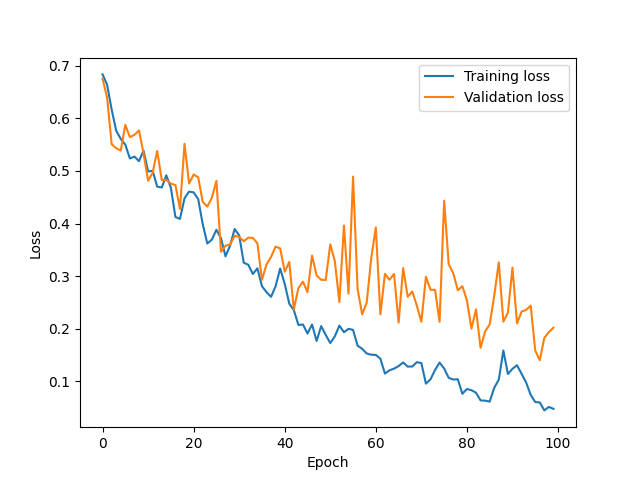

In [21]:
# Plot the results
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


# Create submission file using model predictions

In [ ]:
# Load the test set from kaggle into this workspace
test_set = np.load('/kaggle/input/ix-neuroengineering-symposium-epilepsy-challenge/test_set.npy')

# Convert to tensor and create DataLoader
tensor_x_test = torch.Tensor(test_set)
test_data = TensorDataset(tensor_x_test)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Get model predictions
model.eval()
predictions = []
with torch.no_grad():
    for inputs in test_loader:
        outputs = model(inputs[0].to(device))
        probabilities = torch.sigmoid(outputs).cpu().numpy()  # Convert to numpy array
        binary_predictions = (probabilities > 0.5).astype(int)  # Apply threshold
        predictions.extend(binary_predictions)

# Convert binary predictions to scalar values (0 or 1)
predictions = [pred.item() for pred in predictions]

# Create submission file
with open("submission.csv", "w") as f:
    f.write("win_id,label\n")
    for i, pred in enumerate(predictions):
        f.write(f"{i},{pred}\n")

In [104]:
# Load the test set
test_set = np.load('test_set.npy')

# Scaling the data 
scaler = RobustScaler()
X_test = test_set.reshape(-1, test_set.shape[-1])
X_test = scaler.fit_transform(X_test)
X_test = X_test.reshape(-1, 2, 2000)

# Convert to tensor and create DataLoader
tensor_x_test = torch.Tensor(X_test)
test_data = TensorDataset(tensor_x_test)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Get model predictions
InceptionTime.eval()
predictions = []
with torch.no_grad():
    for inputs in test_loader:
        inputs = inputs[0].to(device)
        outputs = InceptionTime(inputs)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())

# Create submission file
with open("submission.csv", "w") as f:
    f.write("win_id,label\n")
    for i, pred in enumerate(predictions):
        f.write(f"{i},{pred}\n")

### Test the accuracy of model predictions in the validation dataset

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [18]:
InceptionTime.eval()

with torch.no_grad():
        y_pred = InceptionTime(tensor_x_val.to(device)).cpu().numpy()



In [19]:
print(y_pred)
print(y_pred.shape)



#print(accuracy_score(y_val, y_pred))
#print(f1_score(y_val, y_pred))

[[-2.3581963 ]
 [-2.2432187 ]
 [ 3.7742226 ]
 [-3.535383  ]
 [ 4.4141235 ]
 [-2.6024897 ]
 [-5.2525077 ]
 [-3.3087199 ]
 [-0.09297614]
 [-3.4025877 ]
 [ 1.7263284 ]
 [-3.3599355 ]
 [-4.371528  ]
 [-3.0392172 ]
 [-2.63822   ]
 [ 5.3586974 ]
 [-3.2616415 ]
 [-3.9504077 ]
 [-2.5762665 ]
 [ 0.02331093]
 [-3.1030412 ]
 [-0.76115906]
 [-2.3452294 ]
 [-3.5714405 ]
 [-1.7991862 ]
 [-4.0585246 ]
 [-3.3564885 ]
 [-2.60434   ]
 [-2.338391  ]
 [-1.6522639 ]
 [-0.88237906]
 [ 3.2488573 ]
 [-2.835746  ]
 [ 3.5994503 ]
 [-4.479032  ]
 [-1.5612221 ]
 [-2.0279913 ]
 [-3.715059  ]
 [-3.430147  ]
 [-3.5665882 ]
 [-3.206144  ]
 [-1.8446596 ]
 [ 3.7233312 ]
 [-3.1413887 ]
 [-2.728559  ]
 [-2.1567953 ]
 [ 3.3018892 ]
 [-3.8062937 ]
 [-4.3839684 ]
 [-1.1447252 ]
 [-3.1697986 ]
 [-4.486357  ]
 [-4.1619854 ]
 [-2.4401224 ]
 [-4.586807  ]
 [ 2.73263   ]
 [ 3.7414925 ]
 [-2.4900527 ]
 [-3.7814767 ]
 [-0.5152538 ]
 [-4.0678144 ]
 [-3.4086754 ]
 [-1.8665456 ]
 [-3.9978468 ]
 [-2.4723957 ]
 [-3.9852188 ]
 [ 1.39586

In [26]:
# assign 1 when y_pred > 0 and 0 otherwise
predictions = (y_pred > 0).astype(int)

print(len(predictions[predictions>0]))

print(accuracy_score(y_val, predictions))

86
0.9611111111111111


In [28]:
# Load the test set
X_test = np.load('test_set.npy')

# Scaling the data 
scaler = RobustScaler()
X_test = X_test.reshape(-1, X_test.shape[-1])
X_test = scaler.fit_transform(X_test)
X_test = X_test.reshape(-1, 2, 2000)

# Convert to tensor
tensor_x_test = torch.Tensor(X_test)


# Get model predictions
InceptionTime.eval()
with torch.no_grad():
    y_pred = InceptionTime(tensor_x_test.to(device)).cpu().numpy()




279


In [35]:
predictions = (y_pred > -2.5).astype(int).squeeze()

# Create submission file
with open("submission.csv", "w") as f:
    f.write("win_id,label\n")
    for i, pred in enumerate(predictions):
        f.write(f"{i},{pred}\n")
        
print(len(predictions[predictions>0]))

85


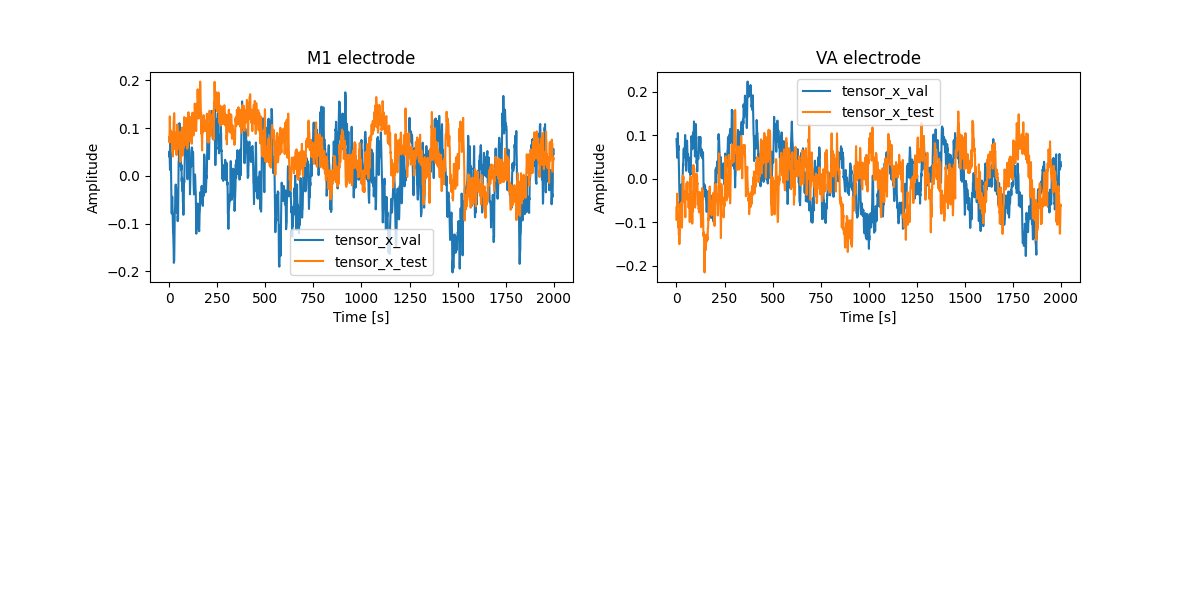

In [37]:
# Plot the average time series of each channel (2nd dimension) of tensor_x_val and tensor_x_test

# Convert tensors to numpy arrays
tensor_x_val_plt = tensor_x_val.numpy()
tensor_x_test_plt = tensor_x_test.numpy()

# Using a subplot for each channel
plt.figure(figsize=(12,6))
plt.subplot(2, 2, 1)
plt.title('M1 electrode')
plt.plot(np.squeeze(np.mean(tensor_x_val_plt[:,0,:], axis=0)), label='tensor_x_val')
plt.plot(np.squeeze(np.mean(tensor_x_test_plt[:,0,:], axis=0)), label='tensor_x_test')
plt.legend()
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

plt.subplot(2, 2, 2)
plt.title('VA electrode')
plt.plot(np.squeeze(np.mean(tensor_x_val_plt[:,1,:], axis=0)), label='tensor_x_val')
plt.plot(np.squeeze(np.mean(tensor_x_test_plt[:,1,:], axis=0)), label='tensor_x_test')
plt.legend()
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

plt.show()


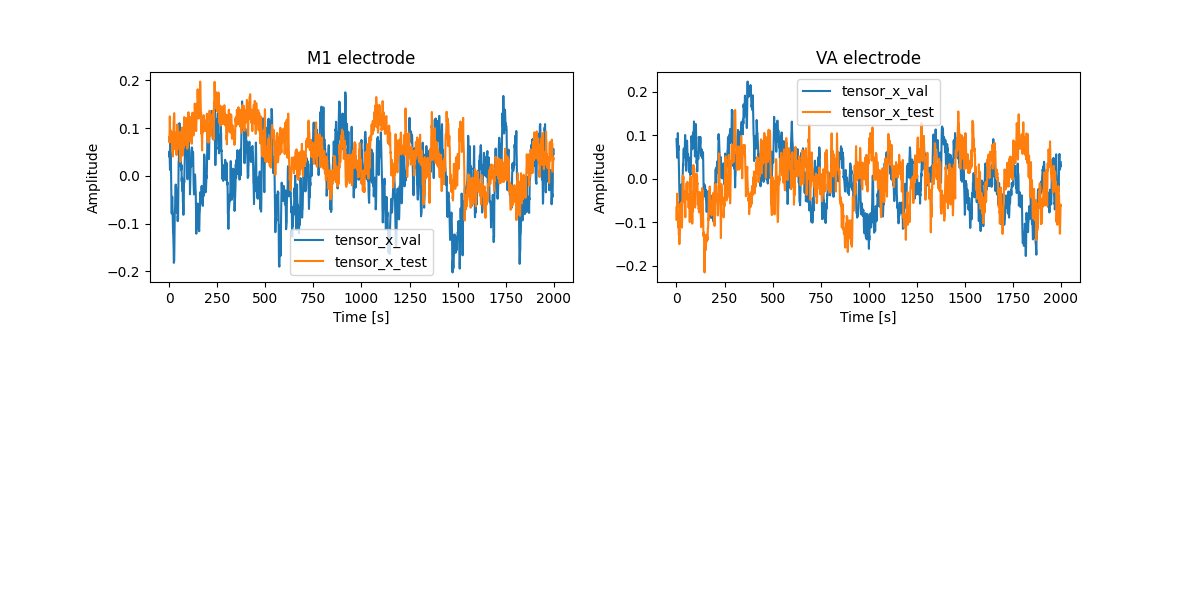

In [38]:
# Define the animation function
def animate(i):
    plt.clf()
    plt.subplot(2, 2, 1)
    plt.title('M1 electrode')
    plt.plot(np.squeeze(tensor_x_val_plt[i,0,:]), label='tensor_x_val')
    plt.plot(np.squeeze(tensor_x_test_plt[i,0,:]), label='tensor_x_test')
    plt.legend()
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')

    plt.subplot(2, 2, 2)
    plt.title('VA electrode')
    plt.plot(np.squeeze(tensor_x_val_plt[i,1,:]), label='tensor_x_val')
    plt.plot(np.squeeze(tensor_x_test_plt[i,1,:]), label='tensor_x_test')
    plt.legend()
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')

# Create the animation
ani = animation.FuncAnimation(plt.gcf(), animate, frames=300, interval=200)

# Show the animation
plt.show()
